In [ ]:
#| default_exp convert_proto_timeseries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import numpy as np
import MachSysS.gymir_result_pb2 as proto
import logging


# Define logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
ch.setFormatter(formatter)

logger.addHandler(ch)


def convert_proto_timeseries_to_pd_series(proto_timeseries: proto.TimeSeriesResult) -> pd.Series:
    """Convert a TimeSeriesResult proto message to a pandas Series for propulsion power"""
    time = map(lambda each: each.epoch_s, proto_timeseries.propulsion_power_timeseries)
    propulsion_power = map(
        lambda each: each.propulsion_power_kw, proto_timeseries.propulsion_power_timeseries
    )
    return pd.Series(index=time, data=propulsion_power)


def convert_proto_timeseries_to_pd_dataframe(proto_timeseries: proto.TimeSeriesResult) -> pd.DataFrame:
    """
    Convert a TimeSeriesResult proto message to a pandas DataFrame
    for propulsion and auxiliary power and other operational parameters such as speed and draft
    """
    time = list(map(lambda each: each.epoch_s, proto_timeseries.propulsion_power_timeseries))
    propulsion_power = list(map(
        lambda each: each.propulsion_power_kw, proto_timeseries.propulsion_power_timeseries
    ))
    auxiliary_power = list(map(
        lambda each: each.auxiliary_power_kw, proto_timeseries.propulsion_power_timeseries
    ))
    if (np.array(auxiliary_power) == 0).all():
        auxiliary_power = [proto_timeseries.auxiliary_power_kw] * len(time)
    df = pd.DataFrame(
        index=time,
        data=dict(
            propulsion_power_kw=propulsion_power,
            auxiliary_power_kw=auxiliary_power,
        )
    )
    if len(proto_timeseries.operation_profile) > 0:
        time_operation_profile = list(map(
            lambda each: each.epoch_s, proto_timeseries.operation_profile
        ))
        speed_array = np.array(list(map(
            lambda each: each.speed_kn, proto_timeseries.operation_profile
        )))
        draft_array = np.array(list(map(
            lambda each: each.draft_m, proto_timeseries.operation_profile
        )))

        if time_operation_profile != time:
            logger.warning(
                "Time in operation profile is not the same as in propulsion power."
                "The operation profile will be interpolated to match the propulsion power time."
            )
            time_array = np.array(time_operation_profile)
            time_array_ref = np.array(time)
            speed_array = np.interp(time_array_ref, time_array, speed_array)
            draft_array = np.interp(time_array_ref, time_array, draft_array)

        df["speed_kn"] = speed_array
        df["draft_m"] = draft_array
    return df

In [1]:
from MachSysS.convert_proto_timeseries import (
    convert_proto_timeseries_to_pd_series, 
    convert_proto_timeseries_to_pd_dataframe,
)
from MachSysS.gymir_result_pb2 import TimeSeriesResult, PropulsionPowerInstance, OperationProfilePoint
import numpy as np
import random

2023-11-06 22:59:11,856 - MachSysS.convert_proto_timeseries - WARNING - Time in operation profile is not the same as in propulsion power.The operation profile will be interpolated to match the propulsion power time.


<Axes: >

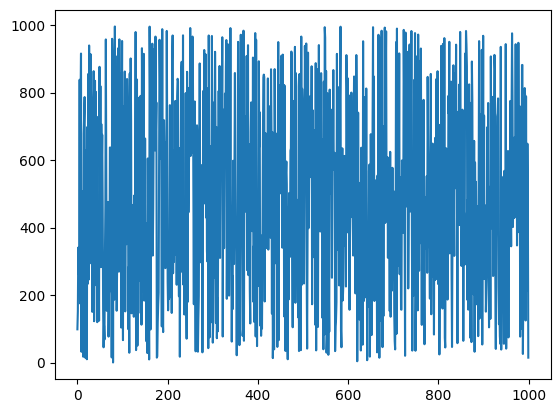

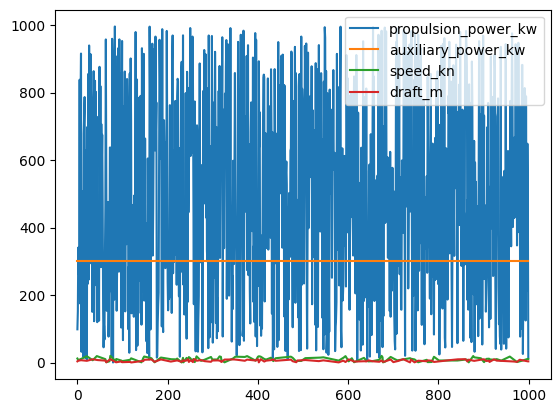

In [2]:
time_array = np.arange(0, 1000, 1)
propulsion_power_array = np.random.random(len(time_array)) * 1000
auxiliary_power = 300
speed_array = np.random.random(len(time_array)) * 20
draft_array = np.random.random(len(time_array)) * 10

timeseries_result = TimeSeriesResult()
timeseries_result.auxiliary_power_kw = auxiliary_power
for time, propulsion_power, speed_kn, draft_m in zip(
        time_array, propulsion_power_array, speed_array, draft_array
):
    timeseries_result.propulsion_power_timeseries.append(PropulsionPowerInstance(
        epoch_s=time, propulsion_power_kw=propulsion_power
    ))
    if random.random() > 0.9:
        timeseries_result.operation_profile.append(OperationProfilePoint(
            epoch_s=time, speed_kn=speed_kn, draft_m=draft_m
        ))

with open("timeseries_test.sim", "wb") as file:
    file.write(timeseries_result.SerializeToString())

time_series = convert_proto_timeseries_to_pd_series(timeseries_result)
time_series.plot()

time_series = convert_proto_timeseries_to_pd_dataframe(timeseries_result)
time_series.plot()

2023-11-06 22:59:13,066 - MachSysS.convert_proto_timeseries - WARNING - Time in operation profile is not the same as in propulsion power.The operation profile will be interpolated to match the propulsion power time.


<Axes: >

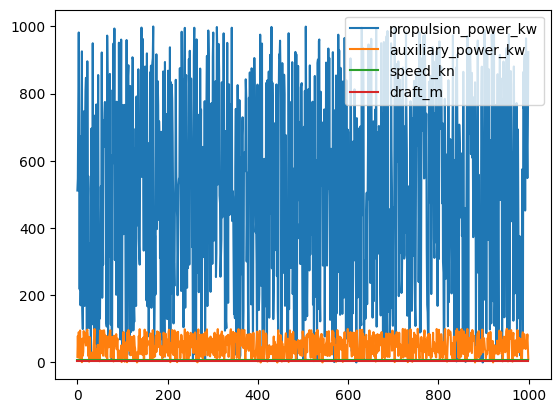

In [3]:
time_array = np.arange(0, 1000, 1)
propulsion_power_array = np.random.random(len(time_array)) * 1000
auxiliary_power_array = np.random.random(len(time_array)) * 100
speed_array = np.random.random(len(time_array)) * 20
draft_array = np.random.random(len(time_array)) * 10

timeseries_result = TimeSeriesResult()
for time, propulsion_power, auxiliary_power in zip(time_array, propulsion_power_array, auxiliary_power_array):
    timeseries_result.propulsion_power_timeseries.append(PropulsionPowerInstance(
        epoch_s=time,
        propulsion_power_kw=propulsion_power,
        auxiliary_power_kw=auxiliary_power
    ))
    if random.random() > 0.9:
        timeseries_result.operation_profile.append(OperationProfilePoint(
            epoch_s=time, speed_kn=speed_kn, draft_m=draft_m
        ))

with open("timeseries_test_.sim", "wb") as file:
    file.write(timeseries_result.SerializeToString())

time_series = convert_proto_timeseries_to_pd_dataframe(timeseries_result)
assert np.allclose(time_series["auxiliary_power_kw"].values, auxiliary_power_array)
time_series.plot()